In [2]:
import numpy as np
import os
from torchvision import transforms
import dv_processing as dv
from datetime import timedelta
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.animation as animation
from IPython.display import Video


C:\Users\LENOVO\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0. Plotting utils

In [2]:
def plot_results(train_losses, val_losses, train_accs, val_accs, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')

    plt.legend()
    plt.suptitle(f'Training and Validation Loss and Accuracy of the {model_name} model')
    plt.show()

def visualize_top_errors(model, test_dataloader, model_name, top_n=5, save_path='top_errors.mp4'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    errors = []  # list of (sequence index, error_count_of_each_sequence)

    with torch.no_grad():
        batch_count = 0
        for sequence, target in test_dataloader:
            sequence = sequence.to(device)
            target = target.to(device)
            output = model(sequence)  # (batch_size, sequence_length, 2)

            for i in range(sequence.size(0)):
                error_count = (output[i].argmax(dim=-1) != target[i]).sum().item()
                errors.append((batch_count * test_dataloader.batch_size + i, error_count))

            batch_count += 1

    top_errors = sorted(errors, key=lambda x: x[1], reverse=True)[:top_n]

    sequences = []
    targets = []
    outputs = []
    class_to_idx = {0: 'no_press', 1: 'press'}

    for i, (sequence_idx, error_count) in enumerate(top_errors):
        sequence, target = test_dataloader.dataset[sequence_idx] # sequence: (sequence_length, 1, 32, 32), target: int
        output = model(sequence.unsqueeze(0).to(device))
        sequences.append(sequence)
        targets.append(target)
        outputs.append(output)

    fig, axs = plt.subplots(1, top_n, figsize=(top_n * 4, 4))
    for ax in axs:
        ax.axis('off')
    plt.suptitle(f'Top {top_n} errors of the {model_name} model')

    def init():
        for i, (sequence_idx, error_count) in enumerate(top_errors):
            img = axs[i].imshow(sequences[i][0].squeeze(), cmap='gray')
            axs[i].set_title(f"Target: {class_to_idx[targets[i]]}, Error count: {error_count} ")
        return img,

    def animate(i):
        for j, (sequence_idx, error_count) in enumerate(top_errors):
            img = axs[j].imshow(sequences[j][i].squeeze(), cmap='gray')
            axs[j].set_title(f"Target: {class_to_idx[targets[j]]}, Error count: {error_count} ")
            # Clear previous text
            for txt in axs[j].texts:
                txt.set_visible(False)
            # Display the prediction of the model on the top right corner
            axs[j].text(0.95, 0.05, f"Prediction: {class_to_idx[outputs[j][0][i].argmax(dim=-1).item()]}", color='white',
                        ha='right', va='bottom', transform=axs[j].transAxes)

        return img,

    ani = animation.FuncAnimation(fig, animate, frames=sequences[0].size(0), init_func=init, interval=100, blit=True)
    ani.save(save_path, writer='ffmpeg', fps=30)
    plt.show()


## 1. Transform raw data (aedat4 files) to transformed tensor sequences

In [2]:
def dv_data_frame_tSlice(file_path, duration):
    capture = dv.io.MonoCameraRecording(file_path)
    frames = []
    if not capture.isEventStreamAvailable():
        raise RuntimeError("Input camera does not provide an event stream.")

    # Initialize an accumulator with some resolution
    accumulator = dv.Accumulator(capture.getEventResolution())

    # Apply configuration, these values can be modified to taste
    accumulator.setMinPotential(0.0)
    accumulator.setMaxPotential(1.0)
    accumulator.setNeutralPotential(0.5)
    accumulator.setEventContribution(0.15)
    accumulator.setDecayFunction(dv.Accumulator.Decay.EXPONENTIAL)
    accumulator.setDecayParam(1e+6)
    accumulator.setIgnorePolarity(False)
    accumulator.setSynchronousDecay(False)

    slicer = dv.EventStreamSlicer()

    def slicing_callback(events: dv.EventStore):
        accumulator.accept(events)
        frame = accumulator.generateFrame()
        # frame = np.array(frame)
        # frame = frame.astype(np.uint8)
        frames.append(frame.image)

    slicer.doEveryTimeInterval(timedelta(milliseconds=duration), slicing_callback)

    while capture.isRunning():
        events = capture.getNextEventBatch()
        if events is not None:
            slicer.accept(events)

    return frames

def preprocess_frames(frames, target_size=(32, 32)):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((32, 32)),  # Resize the images if needed
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),         # Convert images to tensor
        transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize
    ])
    preprocessed_frames = [transform(frame) for frame in frames]
    return preprocessed_frames

def create_sequence(frames, sequence_length=30):
    sequence = []
    for i in range(0, len(frames) - sequence_length, sequence_length):
        sequence.append(frames[i:i + sequence_length])
    return sequence

def aedat4_to_sequences(
        input_dir: str, 
        output_dir: str, 
        duration: int = 10,
        sequence_length: int = 300
    ):
    """
    Convert a directory of aedat4 files (with labels as subdirectories) to sequences of frames and save them as pytorch tensors.
    """
    for label in os.listdir(input_dir):
        label_dir = os.path.join(input_dir, label)
        print("Processing label:", label)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                if file.endswith('.aedat4'):
                    print("Processing file:", file)
                    file_path = os.path.join(label_dir, file)

                    frames = dv_data_frame_tSlice(
                        file_path=file_path,
                        duration=duration
                    )
                    frames = preprocess_frames(frames)
                    sequences = create_sequence(frames, sequence_length=sequence_length)

                    label_output_dir = os.path.join(output_dir, label)
                    os.makedirs(label_output_dir, exist_ok=True)

                    for i, sequence in enumerate(sequences):
                        sequence_tensor = torch.stack(sequence)
                        torch.save(sequence_tensor, os.path.join(label_output_dir, f"{os.path.splitext(file)[0]}_seq_{i}.pt"))

In [4]:
input_dir = "raw_data"
output_dir = "seq_data"

aedat4_to_sequences(input_dir=input_dir,
                    output_dir=output_dir,
                    duration=10,
                    sequence_length=300)


Processing label: .DS_Store
Processing label: no_press
Processing file: dvSave-2024_06_25_15_33_29.aedat4
Processing file: dvSave-2024_06_25_15_33_56.aedat4
Processing file: dvSave-2024_06_25_15_34_04.aedat4
Processing file: dvSave-2024_06_27_16_26_12.aedat4
Processing file: dvSave-2024_06_27_16_26_23.aedat4
Processing file: dvSave-2024_06_27_16_26_48.aedat4
Processing file: dvSave-2024_06_27_16_26_59.aedat4
Processing file: dvSave-2024_07_02_14_57_17.aedat4
Processing file: dvSave-2024_07_02_14_57_44.aedat4
Processing file: dvSave-2024_07_02_14_57_59.aedat4
Processing file: dvSave-2024_07_02_16_07_04.aedat4
Processing label: press
Processing file: dvSave-2024_06_25_15_32_21.aedat4
Processing file: dvSave-2024_06_27_16_22_11.aedat4
Processing file: dvSave-2024_06_27_16_22_31.aedat4
Processing file: dvSave-2024_06_27_16_23_38.aedat4
Processing file: dvSave-2024_06_27_16_23_49.aedat4
Processing file: dvSave-2024_06_27_16_24_01.aedat4
Processing file: dvSave-2024_06_27_16_24_12.aedat4
Pro

## 2. Visualize transformed sequences

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16712\1311347286.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vid_data1 = torch.load("seq_data/no_press/dvSave-2024_06_25

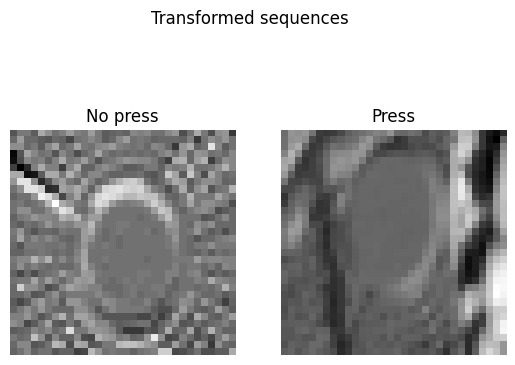

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from IPython.display import Video

# vid_data1 = torch.load("seq_data/no_press/dvSave-2024_06_25_15_33_29_seq_0.pt") # torch.Tensor of shape (300, 1, 32, 32)
# vid_data2 = torch.load("seq_data/press/dvSave-2024_06_25_15_32_21_seq_1.pt") # torch.Tensor of shape (300, 1, 32, 32)

# fig, (ax1, ax2) = plt.subplots(1, 2)
# ax1.axis('off')
# ax1.set_title('No press')
# ax2.axis('off')
# ax2.set_title('Press')
# plt.suptitle('Transformed sequences')

# def init():
#     img1 = ax1.imshow(vid_data1[0].squeeze(), cmap='gray')
#     img2 = ax2.imshow(vid_data2[0].squeeze(), cmap='gray')
#     return img1, img2

# def animate(i):
#     img1 = ax1.imshow(vid_data1[i].squeeze(), cmap='gray')
#     img2 = ax2.imshow(vid_data2[i].squeeze(), cmap='gray')
#     return img1, img2

# ani = animation.FuncAnimation(fig, animate, frames=300, init_func=init, interval=100, blit=True)
# ani.save('test_sequence.mp4', writer='ffmpeg', fps=30)

In [92]:
Video('figures/transformed_sequence.mp4', embed=True)

## 3. Custom dataset + dataloader

In [3]:
class CustomSequenceDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes, self.class_to_idx = self._find_classes(self.root_dir)
        self.samples = self._make_dataset(self.root_dir, self.class_to_idx)
        
    def _find_classes(self, dir):
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def _make_dataset(self, dir, class_to_idx):
        instances = []
        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(dir, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = (path, class_index)
                    instances.append(item)
        return instances

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Returns:
            sequence (torch.Tensor): A sequence of frames of shape (sequence_length, channels, height, width)
            target (int): Target class index
        """
        path, target = self.samples[idx]
        sequence = torch.load(path)
        return sequence, target

In [4]:
dataset = CustomSequenceDataset(root_dir="seq_data")

In [5]:
def create_dataloader(
        data_dir: str,
        batch_size: int,
        num_workers: int = 1
):
    # Create the dataset
    dataset = CustomSequenceDataset(root_dir=data_dir)
   
    # Define the split ratio
    train_ratio = 0.8
    test_ratio = 0.2

    # Calculate the lengths for training and testing
    dataset_size = len(dataset)
    train_size = int(dataset_size * train_ratio)
    test_size = dataset_size - train_size

    # Split the dataset
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoaders for the training and test sets
    train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  )
    test_dataloader = DataLoader(dataset=test_dataset,
                                 batch_size=batch_size,
                                 shuffle=False,
                                 )

    # Check the dataset
    print(f"Number of classes: {len(dataset.classes)}")
    print(f"Class to index mapping: {dataset.class_to_idx}")

    # Check sizes of the splits
    print(f"Total number of sequences: {dataset_size}")
    print(f"Number of training sequences: {len(train_dataset)}")
    print(f"Number of test sequences: {len(test_dataset)}")

    # Iterate over the training DataLoader
    print("Training DataLoader:")
    for images, labels in train_dataloader:
        print(images.shape, labels.shape)
        break

    # Iterate over the test DataLoader
    print("Test DataLoader:")
    for images, labels in test_dataloader:
        print(images.shape, labels.shape)
        break

    print(f"Number of training batches: {len(train_dataloader)}")
    print(f"Number of test batches: {len(test_dataloader)}")
    return train_dataloader, test_dataloader, dataset.classes

In [6]:
train_dataloader, test_dataloader, classes = create_dataloader(
    data_dir="seq_data",
    batch_size=8,
    num_workers=1
)

Number of classes: 2
Class to index mapping: {'no_press': 0, 'press': 1}
Total number of sequences: 75
Number of training sequences: 60
Number of test sequences: 15
Training DataLoader:
torch.Size([8, 300, 1, 32, 32]) torch.Size([8])
Test DataLoader:
torch.Size([8, 300, 1, 32, 32]) torch.Size([8])
Number of training batches: 8
Number of test batches: 2


In [9]:
class LossLogger(pl.Callback):
    def __init__(self, model_name):
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.test_error_counts = [] # list of (sequence index, error_count_of_each_sequence)
        self.model_name = model_name
    
    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get('train_loss')
        train_accuracy = trainer.callback_metrics.get('train_accuracy')
        self.train_losses.append(train_loss.item())
        self.train_accuracies.append(train_accuracy.item())
    
    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get('val_loss')
        val_accuracy = trainer.callback_metrics.get('val_accuracy')
        self.val_losses.append(val_loss.item())
        self.val_accuracies.append(val_accuracy.item())

    def plot_results(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')

        ax2.plot(self.train_accuracies, label='Train Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')

        plt.legend()
        plt.suptitle(f'Training and Validation Loss and Accuracy of the {self.model_name} model')
        plt.show()


## 4. Models

### 4.1 ConvLSTM

In [ ]:
class CNN(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=6,
                      kernel_size=5,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=6,
                      out_channels=16,
                      kernel_size=5,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(16 * 5 * 5, output_size)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, channels, height, width)
        """
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# def visualize_top_errors(model, test_dataloader, model_name, top_n=5, save_path='top_errors.mp4'):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)
#     model.eval()
    
#     errors = []  # list of (sequence index, error_count_of_each_sequence)

#     with torch.no_grad():
#         batch_count = 0
#         for sequence, target in test_dataloader:
#             sequence = sequence.to(device)
#             target = target.to(device)
#             output = model(sequence)  # (batch_size, sequence_length, 2)

#             for i in range(sequence.size(0)):
#                 error_count = (output[i].argmax(dim=-1) != target[i]).sum().item()
#                 errors.append((batch_count * test_dataloader.batch_size + i, error_count))

#             batch_count += 1

class ConvLSTM(pl.LightningModule):
    def __init__(self, output_size):
        super().__init__()
        self.cnn = CNN(output_size)
        self.lstm = nn.LSTM(input_size=output_size,
                            hidden_size=128,
                            num_layers=1,
                            batch_first=True)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, sequence_length, channels, height, width)
        """
        batch_size, sequence_length, channels, height, width = x.size()
        x = x.view(batch_size * sequence_length, channels, height, width)
        x = self.cnn(x) #   (batch_size * sequence_length, output_size)
        x = x.view(batch_size, sequence_length, -1) # (batch_size, sequence_length, output
        x, _ = self.lstm(x) # (batch_size, sequence_length, hidden_size)
        x = self.fc(x) # (batch_size, sequence_length, 2)
        return x

    def common_step(self, batch, batch_idx):
        sequence, target = batch
        output = self(sequence)  # (batch_size, sequence_length, num_classes)
        
        # Calculate loss
        loss = 0
        for t in range(sequence.size(1)):
            loss += nn.CrossEntropyLoss()(output[:, t], target)
        loss /= sequence.size(1)  # Average loss over the sequence length
        
        # Calculate accuracy
        preds = output.argmax(dim=-1)  # (batch_size, sequence_length)
        correct = (preds == target.unsqueeze(1).expand_as(preds)).sum().item()
        total = target.size(0) * sequence.size(1)
        accuracy = correct / total
        return loss, accuracy

    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        
        self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_accuracy', accuracy, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_accuracy', accuracy, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.003)
        return optimizer


In [99]:
model = ConvLSTM(output_size=2)
loss_logger = LossLogger(model_name='ConvLSTM')
trainer = pl.Trainer(max_epochs=50, callbacks=[loss_logger])
trainer.fit(model, train_dataloader, test_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name | Type   | Params | Mode 
----------------------------------------
0 | cnn  | CNN    | 3.4 K  | train
1 | lstm | LSTM   | 67.6 K | train
2 | fc   | Linear | 258    | train
----------------------------------------
71.2 K    Trainable params
0         Non-trainable params
71.2 K    Total params
0.285     Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s]

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17888\68243851.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly all

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 8/8 [00:02<00:00,  3.55it/s, v_num=24, train_loss_step=0.0021, train_accuracy_step=1.000, val_loss=0.105, val_accuracy=0.982, train_loss_epoch=0.00531, train_accuracy_epoch=0.998]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:02<00:00,  3.51it/s, v_num=24, train_loss_step=0.0021, train_accuracy_step=1.000, val_loss=0.105, val_accuracy=0.982, train_loss_epoch=0.00531, train_accuracy_epoch=0.998]


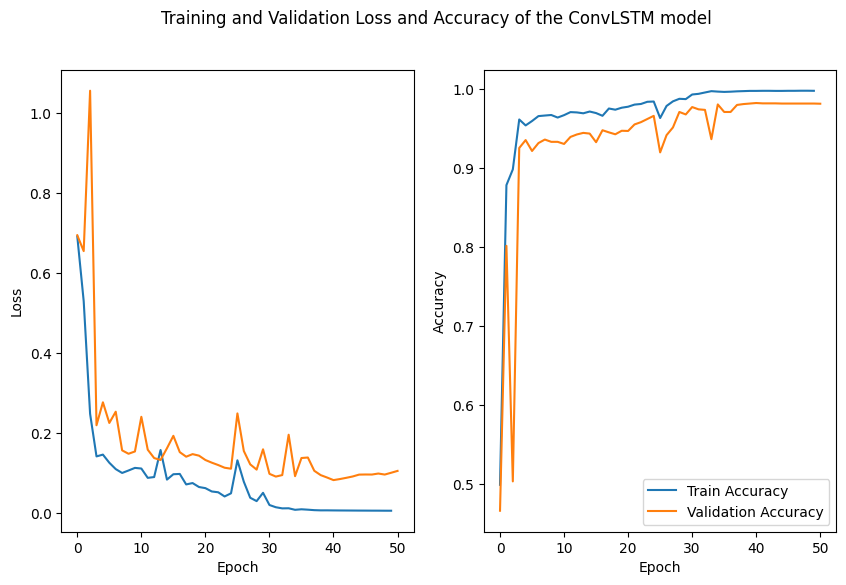

In [100]:
loss_logger.plot_results()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17888\68243851.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sequence = torch.load(path)


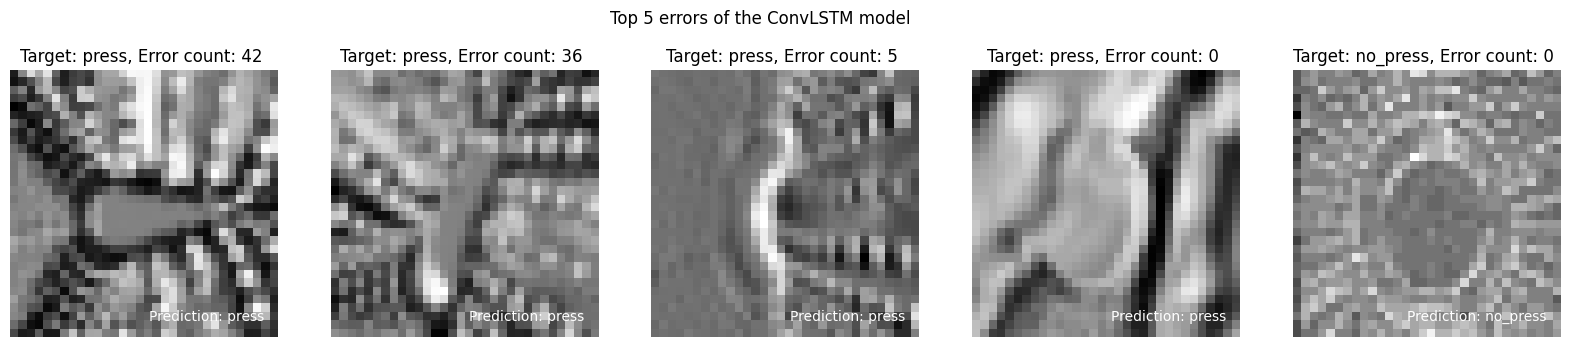

In [101]:
visualize_top_errors(model, test_dataloader, top_n=5, save_path='figures/top_errors_convlstm.mp4', model_name='ConvLSTM')
Video('figures/top_errors_convlstm.mp4', embed=True)

### 4.2 ConvSNN

In [ ]:
import snntorch as snn
import snntorch.functional as SF


class ConvSNN(pl.LightningModule):
    def __init__(self, beta, spikegrad, output_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spikegrad, learn_beta=True, learn_threshold=True)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2) # Output: (batch_size, 6, 14, 14)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spikegrad, learn_beta=True, learn_threshold=True)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2) # Output: (batch_size, 16, 5, 5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spikegrad, learn_beta=True, learn_threshold=True)
        self.fc2 = nn.Linear(120, output_size)
        self.lif4 = snn.Leaky(beta=beta, spike_grad=spikegrad, learn_beta=True, learn_threshold=True)

    def forward(self, x):
        """
            Args:
                x (torch.Tensor): Input tensor of shape (batch_size, seq_len, channels, height, width)
        """
        batch_size, sequence_length, channels, height, width = x.size()

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        spk4_rec = []
        mem4_rec = []

        for t in range(sequence_length):
            x_t = x[:, t] # (batch_size, channels, height, width)
            x_t = self.conv1(x_t) # (batch_size, 6, 28, 28)
            spk1, mem1 = self.lif1(x_t, mem1) # (batch_size, 6, 28, 28)
            x_t = self.pool1(spk1) # (batch_size, 6, 14, 14)

            x_t = self.conv2(x_t) # (batch_size, 16, 10, 10)
            spk2, mem2 = self.lif2(x_t, mem2) # (batch_size, 16, 10, 10) 
            x_t = self.pool2(spk2) # (batch_size, 16, 5, 5)

            x_t = x_t.view(batch_size, -1) # (batch_size, 16 * 5 * 5)
            x_t = self.fc1(x_t) # (batch_size, 120)
            spk3, mem3 = self.lif3(x_t, mem3) # (batch_size, 120)
            x_t = self.fc2(spk3) # (batch_size, output_size)
            spk4, mem4 = self.lif4(x_t, mem4) # (batch_size, output_size)

            spk4_rec.append(spk4)
            mem4_rec.append(mem4)
        
        return torch.stack(spk4_rec, dim=1)# (batch_size, sequence_length,  output_size)

    def common_step(self, batch, batch_idx):
        sequence, target = batch
        spk_rec = self(sequence)  # (batch_size, sequence_length, num_classes)
        # Calculate loss
        loss = 0
        for t in range(sequence.size(1)):
            loss += nn.CrossEntropyLoss()(spk_rec[:, t], target)
        loss /= sequence.size(1)  # Average loss over the sequence length
        
        # Calculate accuracy
        preds = spk_rec.argmax(dim=-1)  # (batch_size, sequence_length)
        correct = (preds == target.unsqueeze(1).expand_as(preds)).sum().item()
        total = target.size(0) * sequence.size(1)
        accuracy = correct / total
        return loss, accuracy
    
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)

        self.log('train_loss', loss.item(), on_epoch=True, prog_bar=True, logger=True)
        self.log('train_accuracy', accuracy, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)

        self.log('val_loss', loss.item(), on_epoch=True, prog_bar=True, logger=True)
        self.log('val_accuracy', accuracy, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0003)


In [11]:
model = ConvSNN(beta=0.9, spikegrad=snn.surrogate.fast_sigmoid(), output_size=2)
loss_logger = LossLogger(model_name='ConvSNN')
trainer = pl.Trainer(max_epochs=50, callbacks=[loss_logger])
trainer.fit(model, train_dataloader, test_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\LENOVO\OneDrive\uet\lab\spike-neural-networks\Spiking-neural-networks-for-event-cameras\tactile_experiment\lightning_logs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | conv1 | Conv2d    | 156    | train
1 | lif1  | Leaky     | 2      | train
2 | pool1 | AvgPool2d | 0      | train
3 | conv2 | Conv2d    | 2.4 K  | train
4 | lif2  | Leaky     | 2      | train
5 | pool2 | AvgPool2d | 0      | train
6 | fc1   | Linear    | 48.1 K | train
7 | lif3  | Leaky     | 2      | train
8 | fc2   | Linear    | 242    | train
9 | lif4  | Leaky     | 2      | train
--------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


tensor([[[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        ...,

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]]])
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:03<00:03,  0.25it/s]tensor([[[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

 

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/8 [00:00<?, ?it/s] tensor([[[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        ...,

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]]], grad_fn=<StackBackward0>)


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


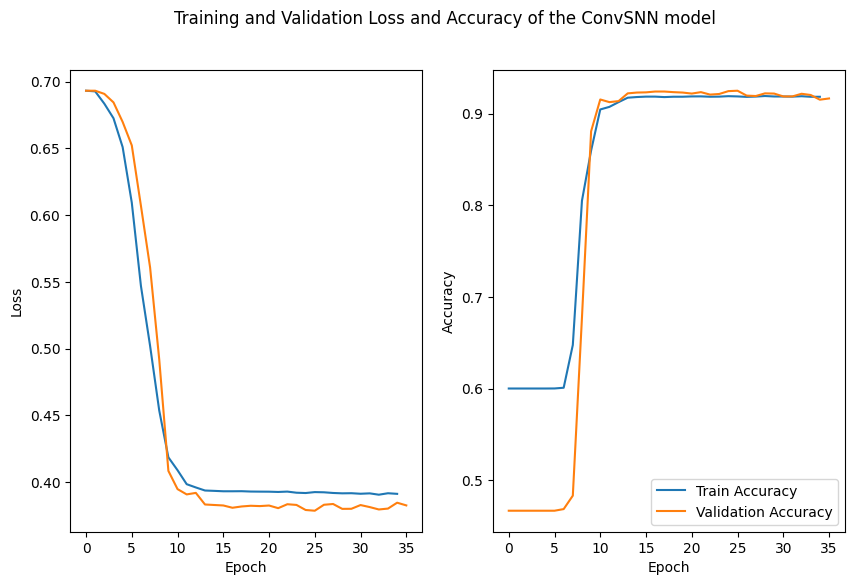

In [ ]:
loss_logger.plot_results()

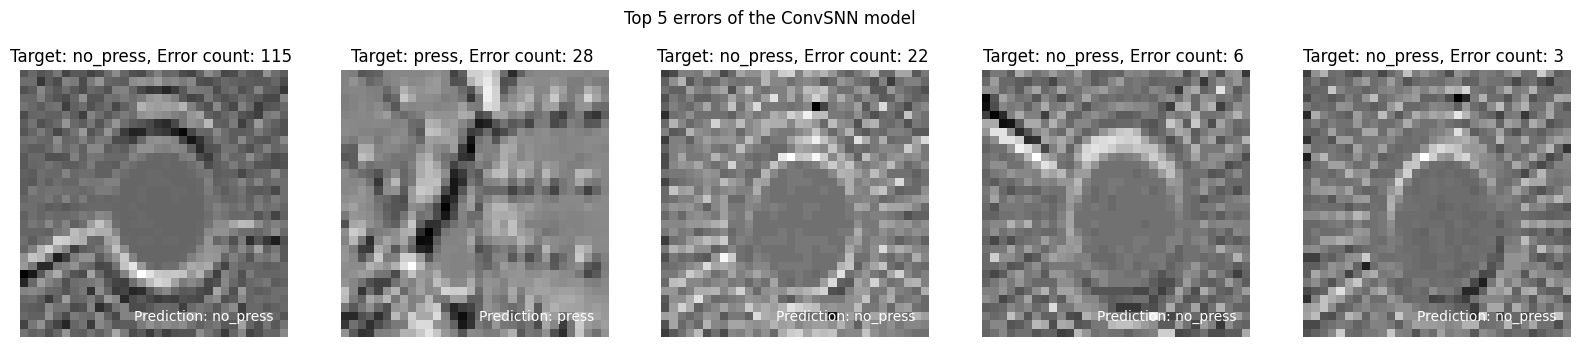

In [ ]:
visualize_top_errors(model, test_dataloader, top_n=5, save_path='figures/top_errors_convsnn2.mp4', model_name='ConvSNN')
Video('figures/top_errors_convsnn2.mp4', embed=True)